In [51]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import wandb
import os

os.environ["WANDB_SILENT"] = "true"
wandb.login()

True

In [52]:
import re

def dumb_tokenizer(text: str):
    text = re.sub("""[.,!?"']""", "", text)
    words = text.lower().split()
    return words

def list_join(l: list, item: any) -> list:
    return [el for pair in zip([item] * len(l), l) for el in pair][1:]

def better_tokenizer(text: str):
    """Now includes punctuation as tokens, as well as a capital letter modifier."""
    # Convert uppercase to modifier and lowercase
    mod_text = ""
    for char in text:
        if char.isupper():
            mod_text += "~"
            mod_text += char.lower()
        else:
            mod_text += char

    # Split by spaces
    words = mod_text.split()

    # Split further into punctuation
    punc = [",", ".", ":", ";", "-", "'", '"', "!", "?", "~"] # tilda represents the capitalization modifier...sus choice

    all_tokens = []
    for word in words:
        tokens = []
        prev = ""
        for i in range(len(word)):
            char = word[i]
            if char in punc:
                tokens.append(prev)
                prev = ""
                tokens.append(char)
            else:
                prev += char

        
        all_tokens += tokens

    return all_tokens

default_tokenizer = dumb_tokenizer
# better_tokenizer is making things awkward, so you might want to include spaces and new lines as tokens as well.

In [53]:
# Build the dataset

def tokenize_file(tokenizer=default_tokenizer):
    # First pass through file to get list
    all_words = set([])
    with open("data/tcitr.txt", "r") as file:
        for line in file:
            all_words.update(tokenizer(line))

    all_words.add("<PAD>")

    vocab_size = len(all_words)
    print("Vocab Size: ", vocab_size)
    word_indices = dict(zip(all_words, range(vocab_size)))
    rev_word_indices = dict(zip(range(vocab_size), all_words))

    # Pass through file again and get token indices
    all_tokens = []
    with open("data/tcitr.txt", "r") as file:
        for line in file:
            indices = [word_indices[token] for token in tokenizer(line)]
            all_tokens += indices
    
    return word_indices, rev_word_indices, all_tokens, vocab_size

word_indices, rev_word_indices, all_tokens, vocab_size = tokenize_file(tokenizer=default_tokenizer)

def build_dataset(seq_len=8):
    # Sliding window
    X, Y = [], []

    cx = [word_indices["<PAD>"]] * seq_len
    for i in range(len(all_tokens)):
        X.append(cx)
        Y.append(all_tokens[i])

        cx = cx[1:] + [all_tokens[i]]

    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)

    # train/val/test split
    split1 = int(0.8 * X.shape[0])
    split2 = int(0.9 * X.shape[0])
    x = {
        "train": X[:split1],
        "validate": X[split1:split2],
        "test": X[split2:]
    }
    y = {
        "train": Y[:split1],
        "validate": Y[split1:split2],
        "test": Y[split2:]
    }

    return x, y

x8, y8 = build_dataset(8)
x16, y16 = build_dataset(16)

Vocab Size:  4629
torch.Size([73667, 8]) torch.Size([73667])
torch.Size([73667, 16]) torch.Size([73667])


In [54]:
class MLP(nn.Module):
    def __init__(self, vocab_size: int, embed_dim=16, seq_len=8, hidden_dim=16):
        super().__init__()
        self.embed_dim = embed_dim
        self.seq_len = seq_len
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear1 = nn.Linear(seq_len * embed_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(hidden_dim, vocab_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, words):
        """Input has shape (num_examples, seq_len)"""

        # Check input is correct size
        if words.shape[1] != self.seq_len:
            raise Exception("Words input is not equal to seq_len of " + str(self.seq_len))

        # Retrieve embeddings, concatenate into NN input
        X = self.embedding(words)
        X = torch.flatten(X, 1) # Flatten everything except for the first dimension (represents the example)

        # Pass through NN and softmax
        a_1 = self.linear1(X)
        z_1 = self.tanh(a_1)
        a_2 = self.linear2(z_1)
        probs = self.softmax(a_2)

        return probs

In [55]:
def prep_input(text: str, seq_len=8, tokenizer=default_tokenizer) -> list[int]:
    indices = [word_indices[word] for word in tokenizer(text)]
    indices = [word_indices["<PAD>"]] * (seq_len - len(indices)) + indices
    return torch.tensor([indices])

def predict_next(prompt: str, model, count=1, seq_len=8) -> list[int]:
    predictions = []
    input = prep_input(prompt, seq_len=seq_len)
    for _ in range(count):
        # Calculate probs, sample
        probs = model(input)
        word = torch.multinomial(probs, 1).item()
        predictions.append(word)

        # Sliding window
        input[:, :-1] = torch.clone(input[:, 1:])
        input[:, -1] = torch.tensor([word])
    
    return predictions

def display_words(words: list[int]) -> str:
    mod_words = []
    skip = False
    for i in range(len(words) - 1):
        if skip:
            continue

        if "~" in word_indices and words[i] == word_indices["~"]:
            word = rev_word_indices[words[i+1]]
            skip = True
            if len(word) == 0:
                continue
            elif len(word) == 1:
                mod_words.append(word[0].upper())
            else:
                mod_words.append(word[0].upper() + word[1:])
        else:
            mod_words.append(rev_word_indices[words[i]])
            skip = False
            
    return " ".join(mod_words)

def gen_predictions(prompt: str, model, n: int=1, count=16, seq_len=8):
    for _ in range(n):
        predictions = predict_next(prompt, model, count=count, seq_len=seq_len)
        print(prompt + " " + display_words(predictions))

In [56]:
def validate_model(model: nn.Module, x: dict[torch.tensor]=x8, y: dict[torch.tensor]=y8, split: str="validate") -> float:
    probs = model(x[split])
    loss = -probs[torch.arange(probs.shape[0]), y[split]].log().mean()

    return loss.item()

In [57]:
def train_model(model: nn.Module, x: dict[torch.tensor]=x8, y: dict[torch.tensor]=y8, epochs: int=100, batch_size: int=2**13, lr: float=0.01, show_loss: int=1, graph_loss=False):
    run = wandb.init(project="the_catcher_in_the_rye", config={
        "batch_size": batch_size,
        "learning_rate": lr,
        "seq_len": x["train"].shape[1],
        "epochs": epochs,
        "dataset": "the_catcher_in_the_rye",
        "model": model._get_name()
    })
    
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        loss = 0
        model.zero_grad()

        # Create mini-batch
        batch_indices = torch.randint(0, x["train"].shape[0], (batch_size,))
        x_batch = x["train"][batch_indices]
        y_batch = y["train"][batch_indices]

        probs = model(x_batch)
        loss += -probs[torch.arange(probs.shape[0]), y_batch].log().mean()
        
        loss.backward()
        opt.step()

        wandb.log({ "loss": loss.item() })
        losses.append(loss.item())
        if epoch % show_loss == 0:
            print(f"Epoch {epoch} Loss: {loss}")
        
    print("Validation Loss: ", validate_model(model, x=x, y=y))
    if show_loss:
        plt.plot(torch.arange(len(losses)), losses)
    
    wandb.finish()
    # run.display()

Epoch 0 Loss: 8.485965728759766
Epoch 100 Loss: 5.383853435516357
Validation Loss:  5.799929141998291


loss,█▇▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
loss,4.72218


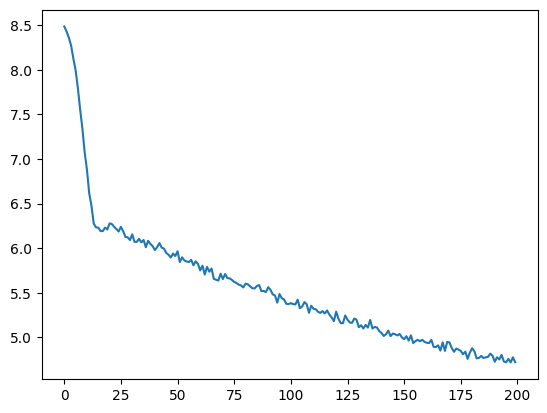

In [58]:
mlp_sm = MLP(vocab_size, embed_dim=16, seq_len=8, hidden_dim=32)
train_model(mlp_sm, epochs=200, batch_size=2**12, lr=0.01, show_loss=100)

Epoch 0 Loss: 8.462543487548828
Epoch 50 Loss: 4.991775989532471
Epoch 100 Loss: 4.3499226570129395
Epoch 150 Loss: 4.049247741699219
Epoch 200 Loss: 3.579340934753418
Epoch 250 Loss: 3.5384445190429688
Epoch 300 Loss: 3.1705708503723145
Epoch 350 Loss: 2.9606375694274902
Epoch 400 Loss: 2.766292095184326
Epoch 450 Loss: 2.405715227127075
Validation Loss:  8.707290649414062


loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss,2.29106


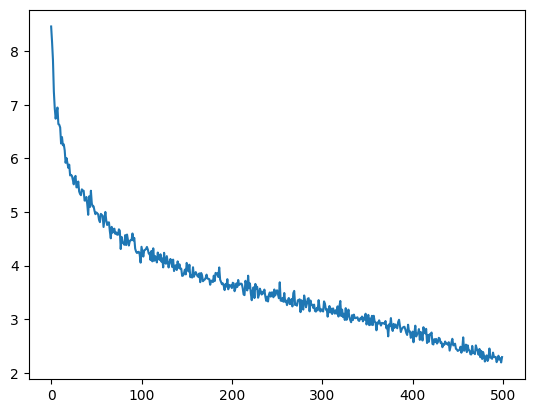

In [59]:
mlp_md = MLP(vocab_size, embed_dim=16, seq_len=8, hidden_dim=1024)
train_model(mlp_md, epochs=500, batch_size=2**10, lr=0.005, show_loss=50)


In [60]:
gen_predictions("hello my name is", mlp_md, 5)
print("Validation: ", validate_model(mlp_md))
print("Test: ", validate_model(mlp_md, split="train"))

hello my name is of hell out of it especially my father a big guy with her when and
hello my name is jim steele hed never said old spencer probably liked him it i said its only
hello my name is of five bucks it had a speech sallys would and at old mrs hayes in
hello my name is ten somewhere you will to nine at the family time he ever sat you say
hello my name is he was the sonuvabitch hes dont about up but you started christ it all i
Validation:  8.707290649414062
Test:  2.2411887645721436


Epoch 0 Loss: 8.461257934570312
Epoch 50 Loss: 5.462352752685547
Epoch 100 Loss: 4.648581504821777
Epoch 150 Loss: 4.456268787384033
Validation Loss:  9.677276611328125


loss,█▇▇▇▆▅▄▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▁▁▁
loss,4.44234


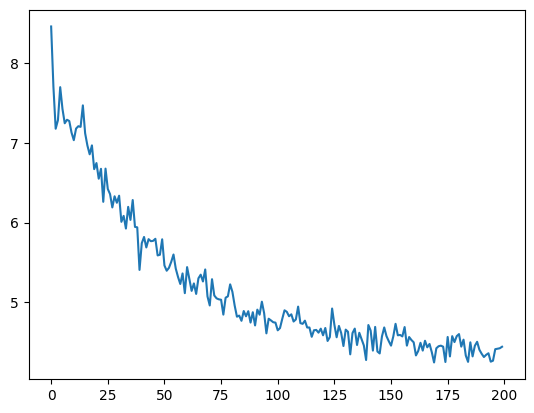

In [61]:
mlp_lg = MLP(vocab_size, embed_dim=16, seq_len=16, hidden_dim=4096)
train_model(mlp_lg, epochs=200, x=x16, y=y16, batch_size=2**10, lr=0.005, show_loss=50)

In [62]:
gen_predictions("He's going to drive me", mlp_lg, seq_len=16)

He's going to drive me was damn what i had a lot too except wanna funny and go anyways look


In [63]:
# Building up to more complicated models now. Start by transfering over your transformer models
# Another experiment to run would be image captioning for image recognition interpretability

class TorchRNN(nn.Module):
    def __init__(self, vocab_size: int, seq_len: int=8, embed_dim: int=16):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_len = seq_len

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, vocab_size, batch_first=True)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, X):
        """Input has shape (num_examples, seq_len)"""

        # Check input is correct size
        if X.shape[1] != self.seq_len:
            raise Exception("Words input is not equal to seq_len of " + str(self.seq_len))

        x = self.embedding(X) # (num_examples, seq_len, embed_dim)
        h_0 = torch.randn(1, x.shape[0], self.vocab_size) # (num_layers, num_examples, vocab_size)
        output, _ = self.rnn(x, h_0) # (num_examples, seq_len, vocab_size)

        output = output[:, -1, :] # Because only want last output

        probs = self.softmax(output)
        return probs

class RNN(nn.Module):
    def __init__(self, vocab_size: int, seq_len: int=8, embed_dim: int=16):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.W_hh = nn.Parameter(torch.randn(vocab_size, vocab_size))
        self.W_xh = nn.Parameter(torch.randn(vocab_size, embed_dim))
        self.W_hy = nn.Parameter(torch.randn(vocab_size, vocab_size))
        self.W_xy = nn.Parameter(torch.randn(vocab_size, embed_dim))

        self.bias_h = nn.Parameter(torch.randn(vocab_size, 1))
        self.bias_y = nn.Parameter(torch.randn(vocab_size, 1))
        self.softmax = nn.Softmax(dim=0)
        self.tanh = nn.Tanh()

    # x should be a one-hot vector
    def forward(self, X):
        """Input has shape (num_examples, seq_len)"""

        # Check input is correct size
        if X.shape[1] != self.seq_len:
            raise Exception("Words input is not equal to seq_len of " + str(self.seq_len))

        x = self.embedding(X) # (num_examples, seq_len, embed_dim)

        h_prev = torch.randn(x.shape[0], self.vocab_size, 1) # (num_examples, vocab_size, 1) Why is this vocab_size and not embed_dim??
        y = torch.empty(x.shape[0], self.seq_len, self.vocab_size) # (num_examples, seq_len, vocab_size)
        for t in range(self.seq_len):
            x_t = x[:, t, :].unsqueeze(dim=-1) # (num_examples, embed_dim, 1)
            h_t = self.tanh(self.W_hh @ h_prev + self.W_xh @ x_t + self.bias_h)
            y_t = self.tanh(self.W_hy @ h_prev + self.W_xy @ x_t + self.bias_y).squeeze(dim=-1) # (num_examples, vocab_size, 1) then squeeze the last dim out

            y[:, t, :] = y_t
            h_prev = h_t

        return self.softmax(y[:, -1, :]) # only want last output, but we practice calculating the rest

In [64]:
torch_rnn = TorchRNN(vocab_size=vocab_size, seq_len=8, embed_dim=16)

Epoch 0 Loss: 8.442811965942383
Epoch 20 Loss: 8.869989395141602
Epoch 40 Loss: 8.879409790039062
Epoch 60 Loss: 8.849993705749512
Epoch 80 Loss: 8.801597595214844
Epoch 100 Loss: 8.92184829711914
Epoch 120 Loss: 8.874359130859375
Epoch 140 Loss: 8.83447551727295
Epoch 160 Loss: 8.82943058013916
Epoch 180 Loss: 8.830862998962402
Validation Loss:  8.870094299316406


loss,▁▆▆▇██▇▇▇▇▆▇▇▇▇▇▇▆▇▇▇▇▇▆▇▇▇▇▆▇▆▇▇▇▇▇▆▇▇▇
loss,8.87731


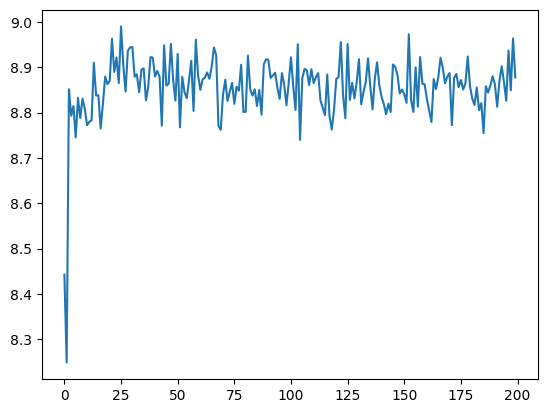

In [65]:
train_model(torch_rnn, epochs=200, lr=0.01, batch_size=2**9, show_loss=20, graph_loss=True)

In [66]:
my_rnn = RNN(vocab_size=vocab_size, seq_len=8, embed_dim=16) # Might be able to reduce embed_dim

Epoch 0 Loss: 7.372585296630859
Epoch 20 Loss: 7.385770797729492
Epoch 40 Loss: 7.3140740394592285
Epoch 60 Loss: 7.397337913513184
Epoch 80 Loss: 7.309211254119873
Validation Loss:  9.307317733764648


loss,▅▅▄▂▂▆▄▄▆▄▃▃▅▃▂█▁▆▅▆▃▃▄▂▇▁▃▄▃▇▃▄▅█▂█▅▅▃▄
loss,7.35258


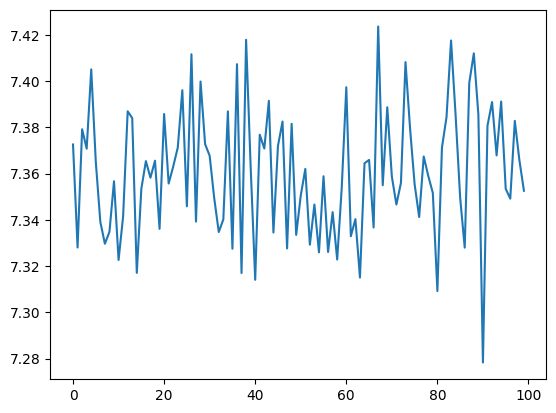

In [67]:
train_model(my_rnn, epochs=100, lr=0.01, batch_size=2**10, show_loss=20, graph_loss=True)

In [68]:
gen_predictions("They advertise in about a thousand", my_rnn, n=5)
# Something seriously wrong here, but same thing is wrong with the PyTorch RNN, so it's probably that you're feeding data incorrectlly.

They advertise in about a thousand henry kill dive gallaghers remembered sadistic jobs less blasé suspect pleasure trains dopy an colleges
They advertise in about a thousand sutton guns guts respectfully somerset chop loud he--are would finger asses--really generally cop peaks fur-
They advertise in about a thousand husband frock fitzgerald stood bunk rained pennsylvania gay lemme pictures enlightening canada eyebrows force anglo-saxons
They advertise in about a thousand fly guys lynn deal adviser guy--he lawyer--like account cases some detective howve likely allowed broke-into
They advertise in about a thousand cooper hoping premature 4b-1 blind -but conceited--and calling lake--i mrs combing had spy anywheres clavichord


In [69]:
class TorchGRU(nn.Module):
    def __init__(self, vocab_size: int, seq_len: int=8, embed_dim: int=16):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_len = seq_len

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, vocab_size, batch_first=True)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, X):
        """Input has shape (num_examples, seq_len)"""

        # Check input is correct size
        if X.shape[1] != self.seq_len:
            raise Exception("Words input is not equal to seq_len of " + str(self.seq_len))

        x = self.embedding(X) # (num_examples, seq_len, embed_dim)
        h_0 = torch.randn(1, x.shape[0], self.vocab_size) # (num_layers, num_examples, vocab_size)
        output, _ = self.gru(x, h_0) # (num_examples, seq_len, vocab_size)

        output = output[:, -1, :] # Because only want last output

        probs = self.softmax(output)
        return probs

class TorchLSTM(nn.Module):
    def __init__(self, vocab_size: int, seq_len: int=8, embed_dim: int=16):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_len = seq_len

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, vocab_size, batch_first=True)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, X):
        """Input has shape (num_examples, seq_len)"""

        # Check input is correct size
        if X.shape[1] != self.seq_len:
            raise Exception("Words input is not equal to seq_len of " + str(self.seq_len))

        x = self.embedding(X) # (num_examples, seq_len, embed_dim)
        h_0 = torch.randn(1, x.shape[0], self.vocab_size) # (num_layers, num_examples, vocab_size)
        c_0 = torch.randn(1, x.shape[0], self.vocab_size) # (num_layers, num_examples, vocab_size)
        output, _ = self.lstm(x, (h_0, c_0)) # (num_examples, seq_len, vocab_size)

        output = output[:, -1, :] # Because only want last output

        probs = self.softmax(output)
        return probs

In [70]:
torch_gru = TorchGRU(vocab_size=vocab_size, seq_len=8, embed_dim=16)
torch_lstm = TorchLSTM(vocab_size=vocab_size, seq_len=8, embed_dim=16)

Epoch 0 Loss: 8.43997573852539
Epoch 20 Loss: 7.772549629211426
Epoch 40 Loss: 7.638345241546631
Epoch 60 Loss: 7.619706630706787
Epoch 80 Loss: 7.456465721130371
Validation Loss:  7.506031036376953


loss,█▇█▇▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁
loss,7.45053


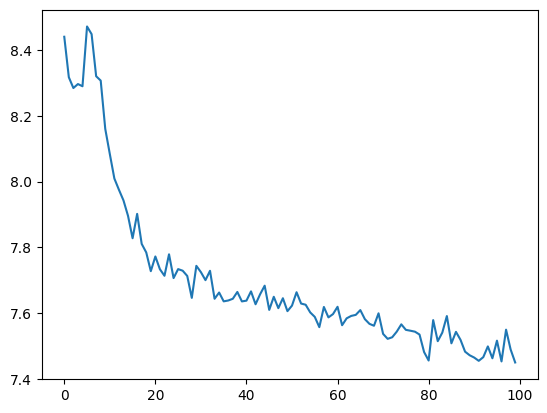

In [71]:
train_model(torch_gru, epochs=100, lr=0.01, show_loss=20, graph_loss=True, batch_size=2**9)

Epoch 0 Loss: 8.440001487731934
Epoch 20 Loss: 7.712592601776123
Epoch 40 Loss: 7.685492515563965
Epoch 60 Loss: 7.711413383483887
Epoch 80 Loss: 7.6856865882873535
Validation Loss:  7.700742244720459


loss,█▆▄▄▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▂▂▁▂▂▂▂▁▂▁▂▂▁▂▂▁▁▁▂▁
loss,7.65674


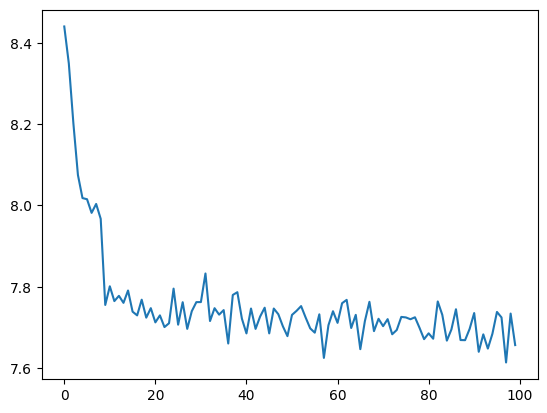

In [72]:
train_model(torch_lstm, epochs=100, lr=0.01, show_loss=20, graph_loss=True, batch_size=2**9)

In [73]:
class GRU(nn.Module):
    """https://arxiv.org/pdf/1406.1078v3.pdf"""
    def __init__(self, vocab_size: int, seq_len: int=8, embed_dim: int=16):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_len = seq_len

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.W_rx = nn.Parameter(torch.randn())

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
    
    def forward(self, X):
        """Input has shape (num_examples, seq_len)"""

        # Check input is correct size
        if X.shape[1] != self.seq_len:
            raise Exception("Words input is not equal to seq_len of " + str(self.seq_len))

        x = self.embedding(X) # (num_examples, seq_len, embed_dim)


        h_prev = torch.randn(x.shape[0], self.vocab_size, 1) # (num_examples, vocab_size, 1) Why is this vocab_size and not embed_dim??
        for t in range(self.seq_len):
            x_t = x[:, t, :].unsqueeze(dim=-1) # (num_examples, embed_dim, 1)

            r_t = self.sigmoid(self.W_rx @ x_t + self.W_rh @ h_prev + self.bias_r)
            z_t = self.sigmoid(self.W_zx @ x_t + self.W_zh @ h_prev + self.bias_z)
            h_tilda_t = self.tanh(self.W @ x_t + self.W_2 @ (r_t * h_prev) + self.bias_h)
            h_t = z_t * h_prev + (1 - z_t) * h_tilda_t

            h_prev = h_t


        output = h_prev.squeeze(dim=-1) # (num_examples, vocab_size)

        probs = self.softmax(output)
        return probs

class LSTM(nn.Module):
    """http://www.bioinf.jku.at/publications/older/2604.pdf"""
    def __init__(self, vocab_size: int, seq_len: int=8, embed_dim: int=16):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_len = seq_len

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, X):
        """Input has shape (num_examples, seq_len)"""

        # Check input is correct size
        if X.shape[1] != self.seq_len:
            raise Exception("Words input is not equal to seq_len of " + str(self.seq_len))

        x = self.embedding(X) # (num_examples, seq_len, embed_dim)
        h_prev = torch.randn(1, x.shape[0], self.vocab_size) # (num_layers, num_examples, vocab_size)
        c_prev = torch.randn(1, x.shape[0], self.vocab_size) # (num_layers, num_examples, vocab_size)

        for i in range(self.seq_len):
            x_t = x[:, i, :]
            i_t = self.sigmoid(self.W_xi @ x_t + self.W_hi @ h_prev + self.bias_i)
            f_t = self.sigmoid(self.W_xf @ x_t + self.W_hf @ h_prev + self.bias_f)
            o_t = self.sigmoid(self.W_xo @ x_t + self.W_ho @ h_prev + self.bias_o)
            g_t = self.tanh(self.W_xg @ x_t + self.W_hg @ h_prev + self.bias_g)

            c_t = f_t * c_prev + i_t * g_t
            h_t = o_t * self.tanh(c_t)

            h_prev = h_t
            c_prev = c_t
            

        output = h_prev[:, -1, :] # Because only want last output

        probs = self.softmax(output)
        return probs